*Luis Antonio Ortega Andrés    
Antonio Coín Castro*

In [11]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, Aer, IBMQ, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector

from scipy.stats import uniform
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

# Load IBM account
provider = IBMQ.load_account()

/home/antcc/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-25 13:45:44,676: Credentials are already in use. The existing account in the session will be replaced.


# Generador de números aleatorios cuántico

Vamos a construir un generador de números aleatorios de 8 bits a partir de un circuito cuántico. Para ello, aprovecharemos una de las puertas cuánticas más conocidas: la **puerta de Hadamard**. Se trata de una puerta de un qubit con la siguiente representación matricial:

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}.$$

Si $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$ es un qubit genérico, se tiene:

$$H|\psi\rangle =\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix}\alpha\\\beta\end{pmatrix}=\frac{1}{\sqrt{2}}\begin{pmatrix}\alpha + \beta\\\alpha -\beta\end{pmatrix}= \frac{\alpha+\beta}{\sqrt{2}}|0\rangle + \frac{\alpha-\beta}{\sqrt{2}}|1\rangle.$$

Podemos obervar que, en el caso particular de que $|\psi\rangle=|0\rangle$ ($\alpha=1, \beta=0$), esta puerta crea una **superposición de estados**, es decir, si realizamos una medición a la salida tendremos la misma probabilidad de obtener tanto $|0\rangle$ como $|1\rangle$. 

Utilizando esta idea, podemos ver la aplicación de una puerta $H$ partiendo del estado $|0\rangle$ como una manera de generar un bit aleatorio. Si queremos generar $b$ bits aleatorios, solo debemos colocar $b$ puertas $H$ en paralelo, todas ellas con qubit inicial $|0\rangle$. Tras realizar la medición obtendremos entonces $b$ bits aleatorios, cuya concatenación será un número (binario) aleatorio de $b$ bits.

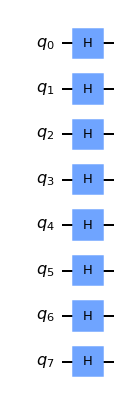

In [6]:
# Create 8 qubits
q = QuantumRegister(8, 'q')
# Create a circuit
circuit = QuantumCircuit(8)
# Apply Hadamard gate to all qubits
circuit.h(q)

circuit.draw('mpl')

Como vimos cuando analizamos el caso de puertas en paralelo, podríamos construir la matriz unitaria del circuito haciendo el producto tensor de todas las matrices que intervienen, es decir, sería $H^{\otimes 8}$. No es difícil observar que la matriz $H_m := H^{\otimes m}$, de dimensiones $2^m\times 2^m$, sigue la siguiente relación de recurrencia:
$$H_0=1, H_m = \frac{1}{\sqrt{2}}\begin{pmatrix}H_{m-1} & H_{m-1}\\ H_{m-1} & -H_{m-1}\end{pmatrix}, \quad m \ge 1.$$

In [7]:
backend_unitary = Aer.get_backend('unitary_simulator')
matrix = execute(circuit, backend_unitary).result().get_unitary(decimals=3)
print("Circuit unitary gate (following Qiskit convention):\n", matrix)

Circuit unitary gate (following Qiskit convention):
 [[ 0.0625+0.00000000e+00j  0.0625-7.65404249e-18j  0.0625-7.65404249e-18j
  ...  0.0625-5.35782975e-17j  0.0625-5.35782975e-17j
   0.0625-6.12323400e-17j]
 [ 0.0625+0.00000000e+00j -0.0625+7.65404249e-18j  0.0625-7.65404249e-18j
  ... -0.0625+5.35782975e-17j  0.0625-5.35782975e-17j
  -0.0625+6.12323400e-17j]
 [ 0.0625+0.00000000e+00j  0.0625-7.65404249e-18j -0.0625+7.65404249e-18j
  ...  0.0625-5.35782975e-17j -0.0625+5.35782975e-17j
  -0.0625+6.12323400e-17j]
 ...
 [ 0.0625+0.00000000e+00j -0.0625+7.65404249e-18j  0.0625-7.65404249e-18j
  ... -0.0625+5.35782975e-17j  0.0625-5.35782975e-17j
  -0.0625+6.12323400e-17j]
 [ 0.0625+0.00000000e+00j  0.0625-7.65404249e-18j -0.0625+7.65404249e-18j
  ...  0.0625-5.35782975e-17j -0.0625+5.35782975e-17j
  -0.0625+6.12323400e-17j]
 [ 0.0625+0.00000000e+00j -0.0625+7.65404249e-18j -0.0625+7.65404249e-18j
  ... -0.0625+5.35782975e-17j -0.0625+5.35782975e-17j
   0.0625-6.12323400e-17j]]


Podemos ilustrar también la superposición de estados en la que se encuentra el circuito, donde vemos que todos los qubits están en el ecuador de la esfera de Bloch (equiprobabilidad).

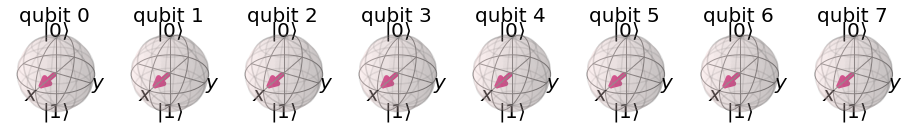

In [8]:
backend_state = Aer.get_backend('statevector_simulator')
psi = execute(circuit, backend_state).result().get_statevector()
plot_bloch_multivector(psi)

Finalmente, realizamos varias ejecuciones del circuito y medimos el número obtenido. Mostramos la frecuencia de ocurrencia de cada número binario en $\{0,1\}^8$ en un histograma.

In [9]:
# Add measurements
circuit.measure_all()

# Set backend proider
backend = provider.get_backend('ibmq_qasm_simulator')

# Execute the circuit 8192 times
job = execute(circuit, backend, shots=8192)
result = job.result()
counts = result.get_counts(circuit)

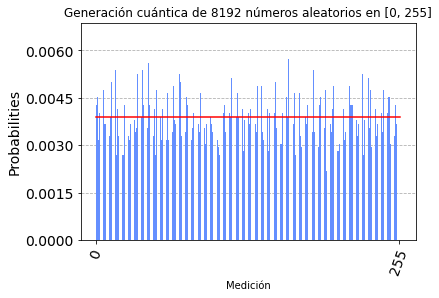

In [12]:
ax = plt.axes()
plot_histogram(counts, ax=ax, bar_labels=False, title = "Generación cuántica de 8192 números aleatorios en [0, 255]")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:d}"))
ax.set_xticks([0, 255])
ax.set_xlabel("Medición")
_ = ax.plot([0, 256], 2*[1./256], color = 'r')

Vemos que el resultado se asemeja bastante a una distribución uniforme. Hemos remarcado la línea $y=1/256$, que representa la probabilidad de elegir un número aleatorio de 8 bits entre los $2^8=256$ posibles. Se observa que todos los valores son observados más o menos con esa probabilidad, por lo que podemos concluir que nuestro generador aleatorio cuántico funciona correctamente.

Podemos comparar el desempeño frente a otros métodos de generación de números aleatorios, por ejemplo el de la librería `scipy`. Vemos que los resultados son similares.

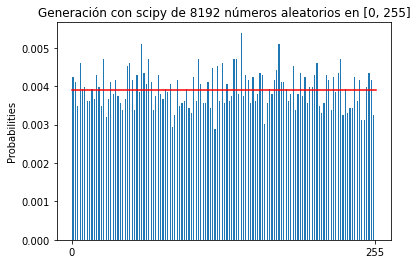

In [13]:
np.random.seed(1)
unif = uniform.rvs(0, 255, 8192)
plt.hist(unif, bins=128, rwidth=0.5, density = True)
plt.xticks([0, 255])
plt.title("Generación con scipy de 8192 números aleatorios en [0, 255]")
plt.ylabel("Probabilities")
_ = plt.plot([0, 256], 2*[1./256], color = 'r')